# Google Trends insight in understanding what drives Norwegians into purchasing an electric vehicle
Authors: 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 
- 314205 - Jostein Leirgulen 

Date: 03.12.2020 

### Abstract:

Norway is well advanced compared to other countries in the expansion of its electric vehicle (EV) fleet thanks to strong incentives (100% tax for combustion vehicles which are exempted for EV). It has even reached the top place in total EV sales despite its country size. Understanding the evolution of EV car sales in Norway could help predicting future sales in other countries. 

Now that we have a working model to assess the predictive power of Google Trends on a certain output, we will then extend this on investigating which set of indicators best improve the short-term prediction of a Norway EV sales. The indicators will be grouped in categories such as environment, car models, infrastructure or policy related. Additionally, we will assess the impact of corner-stone events such as the Paris Climate Accord, the release of the Tesla model 3 as well as the implementation of tax-cuts for EVs in Norway on car sales. All of this will help us assess which category of indicators/events influence most the consumer propensity to switch from combustion to electric.

### Research Questions:

- Which category of indicators influence most EV sales in Norway?  Is it environment, car models, infrastructure (charging stations) or government policies?
- Which event influenced most EV sales in Norway (the Paris Climate Accord, the release of the Tesla model 3 or the implementation of tax-cuts for EVs in Norway)?
- Is there a coherent correlation between the answers of both questions above? 

### Proposed dataset:

1) Opplysningsrådet for Veitrafikk - Road Traffic Information Council

- https://ofv.no/ 
- The data should be bought but as students we managed to request it for free
- We have not accessed the data yet, so we do not know the full content of it and cannot infer its size yet. Most probably it would be at around 100 rows (1 per month for 10 years).

2) Google Trends:

- https://trends.google.com/trends
- We will pick several indicators and investigate which ones help us best in predicting. Indicators will be grouped in these categories:
  - Environment
  - Car models
  - Infrastructure (charging stations)
  - Government policies

### Methods:

We will: 

- use market share of EV versus other vehicles instead of purely sales as our prediction output. Economical factors and policies are meant to drive consumers aways from combustion vehicles and towards EV. If EV sales increase but combustion vehicule sales keep on increasing just as much then the policies are in vain. The true interesting metric is therefore market share instead of pure sales. 
- use the same method in the paper for Motor Vehicles and Parts,  select relevant terms for google trends

- do several experiments to find a suitable match
- use the expanding window to train the data and make prediction

The models will be:

- Base model features: log(mkt_share) = log(mkt_share_1monthlag) + log(mkt_share_12monthslag) 
- Indicators model features: 
  - Base + economic related indicators
  - Base + car model related indicators
  - Base + range anxiety related indicators
  - Base + environment  related indicators
  - Base + all indicators
- Indicators and events model features (Discontinuous regression model): 
  - Base + economic related key dates [1 column for each date with 0 before, 1 after date]
  - Base + car model related key dates
  - Base + range anxiety related key dates
  - Base + environment related key dates
  - Base + all key dates

In [ ]:
# https://github.com/GeneralMills/pytrends
# !pip install pytrends

In [1]:
import pandas as pd 
from dateutil import relativedelta as rdelta
from datetime import datetime, date
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq

## Step 1 - Data wrangling

### Step 1.1 - EV sales and market share

In [2]:
sales = pd.read_csv('data/EV_sales_norway.csv',sep=';')

In [3]:
sales['weekday'] = ''
pd.to_datetime(sales['weekday'])
for index, row in sales.iterrows():
    # minus 1 because the dataset week system goes from 1 to 53 instead of 0 to 52, day start from sunday 0 to macth google trend
    sales.weekday[index] = datetime.strptime('{} {} 0'.format(row.year, row.week-1), '%Y %W %w').strftime("%Y-%m-%d") 
sales.weekday = pd.to_datetime(sales.weekday, format='%Y-%m-%d')
#compute market share for electric cars
sales['ev_share'] = sales['electric']/(sales['other'] + sales['electric'])
sales

C:\Users\Jostein\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,week,other,electric,weekday,ev_share
0,2010,1,17,0,2010-01-03,0.000000
1,2010,2,2776,0,2010-01-10,0.000000
2,2010,3,1953,0,2010-01-17,0.000000
3,2010,4,2078,0,2010-01-24,0.000000
4,2010,5,2873,0,2010-01-31,0.000000
...,...,...,...,...,...,...
572,2020,44,1749,1869,2020-11-01,0.516584
573,2020,45,961,1291,2020-11-08,0.573268
574,2020,46,1174,1435,2020-11-15,0.550019
575,2020,47,1259,1591,2020-11-22,0.558246


C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0, 0.5, 'Weekly car sales')

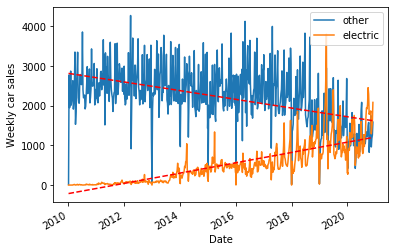

In [4]:
sales.plot('weekday', y=["other", "electric"])

# calc the trendline
z_other = np.polyfit(sales.index, sales.other, 1)
z_elec = np.polyfit(sales.index, sales.electric, 1)
p_other = np.poly1d(z_other)
p_elec = np.poly1d(z_elec)
plt.plot(sales.weekday,p_other(sales.index),"r--")
plt.plot(sales.weekday,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Weekly car sales')

C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'EVs in Norway')

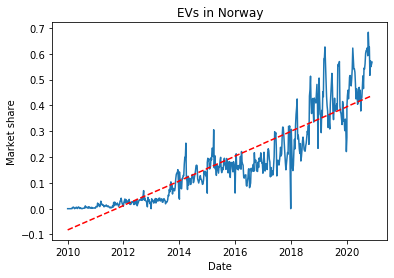

In [5]:
x = sales.weekday
y = sales.ev_share
plt.plot(x,y)

# calc the trendline
z_elec = np.polyfit(sales.index, y, 1)
p_elec = np.poly1d(z_elec)
plt.plot(x,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Market share')
plt.title('EVs in Norway')

### Step 1.2 - Google trend data import and wrangling

In [6]:
# Function goal:      Convert start and end date to a string of dates with specific format
def convert_to_date(satrt,end):
      start = satrt.strftime("%Y-%m-%d")
      end = end.strftime("%Y-%m-%d")
      dates = start + ' ' + end
      return dates

In [7]:
'''
Function goal:      Split timespan in years
Function inputs:    date_start
                    date_end
Function outputs:   years_expand = Array years
'''

def split_data_into_year(date_start, date_end):
    years_expand = []
    start_year = date_start
    while abs(rdelta.relativedelta(start_year,date_end).years) >0 :
      one_year = rdelta.relativedelta(weeks=+50)
      end_year = start_year + one_year
    
      years_expand += [convert_to_date(start_year,end_year)]

      #update start_year
      one_week = rdelta.relativedelta(weeks=+1)
      start_year = end_year + one_week

    years_expand += [convert_to_date(start_year,date_end)]
    return years_expand

In [8]:
'''
Function goal:      Import Google Trends data
Function inputs:    kw = Keyword list 
                    geo = Country abreviation to search
                    dates = Timespan to search
                    eps = maximum propensity difference in matching
Function outputs:   pytrends = full pytrends format dataset
                    interest_over_time_df = Dataframe containing the interest evolution for each keyword
'''

def build_GT_data(kw, geo, dates):

    while True:
        try:
            pytrends.build_payload(kw_list=kw, cat=0, timeframe=dates, geo=geo, gprop='')
            break
        except:    
            pass # Sometimes Google Trends rejects the request. Try again until it works ! 

    interest_over_time_df = pytrends.interest_over_time()

    return interest_over_time_df[kw]

In [9]:
'''
Function goal:      Normalise the weekly values. It finds the date and keyword with the max value in weekly. 
                    Looks for the value in the monthly dataset which is smaller and normalises all the weekly value to this one.
Function inputs:    data_weekly = 1 year of Google Trends data with weekly granularity
                    data_monthly = Whole deseired timespan of Google Trends data with monthly granularity
                    kw = keywords
Function outputs:   data_weekly = same as input but normalised 
'''
def normalise(data_weekly, data_monthly, kw):
    # 1) Convert weekly into monthly with mean()
    data = data_weekly.groupby(data_weekly.index.strftime("%Y-%m")).mean()

    # 2) Find row index and column name of max value (which is not 100 as we have done the mean over 4 weeks)
    yearly_max = data.max().max()
    max_column = data.max().idxmax()
    max_row = data[max_column].idxmax()

    # 3) For the whole timespan (with monhtly datapoints), the value at the weekly max is 'true_max' 
    true_max = data_monthly[max_column].loc[data_monthly.index > max_row].iloc[0]

    # 4) Normalise each weekly datapoints by this true_max/yearly_max in %
    data_weekly = data_weekly*(true_max/yearly_max)/100

    return data_weekly

In [10]:
'''
Function goal:      Split the timespan in years so that we can extract weekly datapoints. 
Function inputs:    data_weekly = 1 year of Google Trends data with weekly granularity
                    interest_monthly = Whole deseired timespan of Google Trends data with monthly granularity
                    kw = keywords
                    yrs = full timespan split into years 'start_date end_date' for each year as a list
                    geo = Country abreviation to search
Function outputs:   interest = full timespan interest with weekly datapoints
'''
def get_weekly_interest(interest_monthly, kw, yrs, geo):
    interest = pd.DataFrame()
    for yearly_dates in yrs:
        interest_weekly = build_GT_data(kw, geo, yearly_dates)
        
        #if the search is for very short timespan it will result in daily instead of weekly values. So we take the weekly mean in case this happens
        interest_weekly['date'] = pd.to_datetime(interest_weekly.index) - pd.to_timedelta(7, unit='d')
        interest_weekly = interest_weekly.groupby(pd.Grouper(key='date', freq='W-SUN')).mean()
        
        interest_weekly = normalise(interest_weekly, interest_monthly, kw)
        interest = pd.concat([interest, interest_weekly])
    #The max week might actually not be around the same date as the max month. Hence we need to normalise again here so that max value is 100
    interest = interest/interest.max().max()*100
    return interest

In [77]:
UTC_offset = 60 # Minutes for Norway (UTC+1)
host_language = 'en_US'
# keywords related to category: economical 
kw_eco = ["Elbil bompenger", "Elbil avgift", "Elbil pris", "Elbil fordeler", "Bompenger"] # REMOVED:, "Bompenger pris", "Parkering pris", "Elbil parkering"] 
# keywords related to category: EV models (top 10 EV models sold in Norway with Tesla models grouped together as 'Tesla')
kw_evm = ["Tesla", "Nissan Leaf","Volkswagen e-Golf", "Bmw I3", "Kia Soul"] # REMOVED:, "Renault Zoe", "Audi E-tron", "Hyundai Ioniq"] 
# keywords related to category: range anxiety 
kw_ran = ["Elbil lading", "Elbil ladestasjoner", "Ladestasjoner", "Hurtiglading", "Elbil rekkevidde"] # REMOVED:, "Tesla supercharger"] 
# keywords related to category: environement 
kw_env = ["Karbonavtrykk", "Luftkvalitet", "CO2", "CO2 bil", "CO2 utslipp"] 
# all keywords grouped
kw_all = kw_eco + kw_evm + kw_ran + kw_env
#date_start = date(2009,12,28) # Sales dataset Timespan
#date_end = date(2020,11,29)
date_start = date(2010,1,3)
date_end = date(2020,1,5)
dates = convert_to_date(date_start,date_end)
yrs = split_data_into_year(date_start, date_end) # Will be usefull to extract yearly datasets to have weekly instead of monthly datapoints
country_abbreviation = 'NO' #Norway abreviation
pytrends = TrendReq(hl=host_language, tz=UTC_offset)

In [78]:
# Step 1: get non granular over results for reference:
# Giving a too large timespan yields unfortunately only monthy results. This will however serve as our reference frame for normalisation
interest_monthly_kw_eco = build_GT_data(kw_eco, country_abbreviation, dates)
interest_monthly_kw_evm = build_GT_data(kw_evm, country_abbreviation, dates)
interest_monthly_kw_ran = build_GT_data(kw_ran, country_abbreviation, dates)
interest_monthly_kw_env = build_GT_data(kw_env, country_abbreviation, dates)

In [79]:
#Step 2: get weekly 
interest_kw_eco = get_weekly_interest(interest_monthly_kw_eco, kw_eco, yrs, country_abbreviation)
interest_kw_evm = get_weekly_interest(interest_monthly_kw_evm, kw_evm, yrs, country_abbreviation)

#NOTE: GOOGLE DOES WEIRD THINGS SOMETIMES. SO YOU MIGHT NEED TO RUN A LINE AGAIN INDIVIDUALLY IF YOU HAVE AN ERROR
#For me it seems like its mainly for 'ran' that it fails but after a while if you run this line individually it works
# When you do too many queries you get rejected by Google Trends. You need to pause before starting again to avoid errors. 60 sec is recommended by pytrends
# Doesn't seem to work though ...
#time.sleep(60) 

interest_kw_ran = get_weekly_interest(interest_monthly_kw_ran, kw_ran, yrs, country_abbreviation)
interest_kw_env = get_weekly_interest(interest_monthly_kw_env, kw_env, yrs, country_abbreviation)

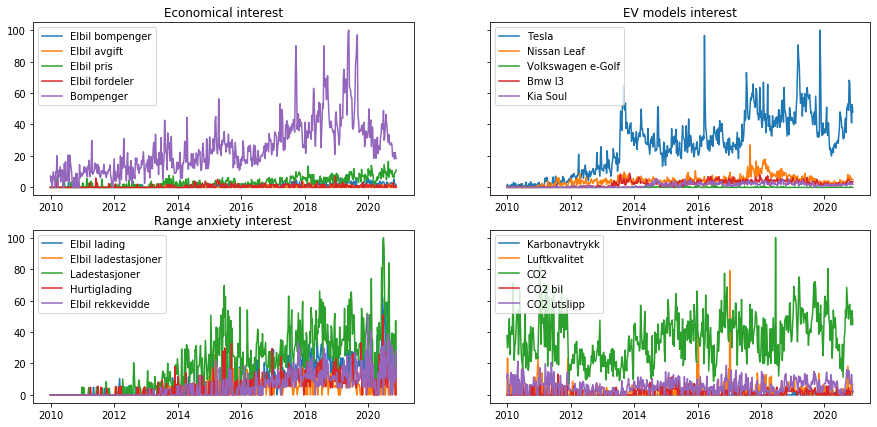

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15,7), sharey=True)

axs[0,0].plot(interest_kw_eco)
axs[0,0].set_title("Economical interest")
axs[0,0].legend(kw_eco)

axs[0,1].plot(interest_kw_evm)
axs[0,1].set_title("EV models interest")
axs[0,1].legend(kw_evm)

axs[1,0].plot(interest_kw_ran)
axs[1,0].set_title("Range anxiety interest")
axs[1,0].legend(kw_ran)

axs[1,1].plot(interest_kw_env)
axs[1,1].set_title("Environment interest")
axs[1,1].legend(kw_env)

### Step 1.3 - Key events definition

In [16]:
# Economical related dates which penalises combustion vehicles (in favor of EV)
dates_eco = {"Climate settlement announcement":"2012-04-24",
             "Kyoto agreement second term":"2013-05-31"}

# EV model key releas dates
# Unknown date of the month for dates_evm so set to 15
dates_evm = {"Tesla model 3 first release":"2019-07-15",
             "Nissan Leaf first release":"2010-12-15"}

# Range anxiety mitigation key dates
dates_ran = {"Tesla supercharging system start":"2013-07-01"}

# Rising environmental awarness key dates
dates_env = {"Paris agreement anouncement":"2015-01-04",
             "Paris agreement updated emission cuts":"2020-02-27"}

# All dates together
dates_all = dict(dates_eco)
dates_all.update(dates_evm)
dates_all.update(dates_ran)
dates_all.update(dates_env)

C:\Users\Jostein\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Jostein\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np

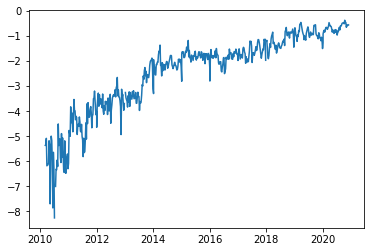

In [17]:
plt.plot(x, np.log(y))

### Step 1.4 - Building DataFrames for each model

- Base model
- Google trends keywords models (5 models: one for each keywords category (among Economical, EV model, Range anxiety and Enviornment) and one for all categories)
- Events models (5 models again)

#### 1.4.1: The base model is defined as: 
- predictor = logarithm?!?! EV market share (log_ev_share)
- features = ((log_))ev_share shifted by 1 month and by 12 months, to build the AR-1 Model (as in our reference paper) 

$$\hat{y}= \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-12}$$

In [18]:
sales_base = sales.copy()

# convert rows to month or year where each row is 1 week
#month_delay = 4
year_delay = 52

#a fix - t-1 should not be 4, which would imply we are trying to use last years week, and four weeks past in order 
# to predict NOW
month_delay = 1

# BOTH LOG AND LINEAR COLUMNS HERE. REMOVE ONE OR THE OTHER WHEN DECIDED: 
sales_base['ev_share_tm1']=sales_base.ev_share.shift(month_delay)
sales_base['ev_share_tm12']=sales_base.ev_share.shift(year_delay)
#replace 0 to a samll number bigger than 1 so that log can be defined
#sales_base['log_ev_share'] = np.log(sales_base.ev_share.replace(0, 0.5))
#sales_base['log_ev_share_tm1']=sales_base.log_ev_share.shift(month_delay)
#sales_base['log_ev_share_tm12']=sales_base.log_ev_share.shift(year_delay)

### Modifications by JOSTEIN
sales_base['log_ev_share'] = np.log(sales_base.ev_share + 0.1)
sales_base['log_ev_share_tm1']=sales_base.log_ev_share.shift(month_delay)
sales_base['log_ev_share_tm12']=sales_base.log_ev_share.shift(year_delay)

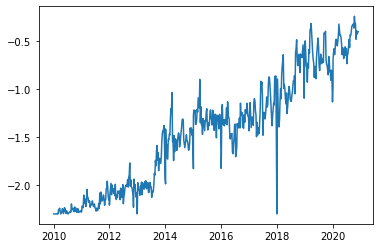

In [19]:
plt.plot(sales_base["weekday"], sales_base["log_ev_share"])

#### 1.4.2 The keywords model 

## Interjection - Dataframes for statsmodels

In [136]:
sales_base

,year,week,other,electric,weekday,ev_share,ev_share_tm1,ev_share_tm12,log_ev_share,log_ev_share_tm1,log_ev_share_tm12
0,2010,1,17,0,2010-01-03,0.000000,NaN,NaN,-2.302585,NaN,NaN
1,2010,2,2776,0,2010-01-10,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2,2010,3,1953,0,2010-01-17,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
3,2010,4,2078,0,2010-01-24,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
4,2010,5,2873,0,2010-01-31,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
...,...,...,...,...,...,...,...,...,...,...,...
572,2020,44,1749,1869,2020-11-01,0.516584,0.626354,0.415139,-0.483561,-0.319717,-0.663319
573,2020,45,961,1291,2020-11-08,0.573268,0.516584,0.397338,-0.395612,-0.483561,-0.698486
574,2020,46,1174,1435,2020-11-15,0.550019,0.573268,0.339404,-0.430753,-0.395612,-0.822336
575,2020,47,1259,1591,2020-11-22,0.558246,0.550019,0.341463,-0.418177,-0.430753,-0.817660


In [172]:
interest_kw_evm

,Tesla,Nissan Leaf,Volkswagen e-Golf,Bmw I3,Kia Soul
date,,,,,
2009-12-27,0.472417,0.000000,0.0,0.000000,0.000000
2010-01-03,1.139360,0.000000,0.0,0.000000,0.000000
2010-01-10,0.889256,0.000000,0.0,0.000000,0.000000
2010-01-17,0.889256,0.000000,0.0,0.000000,0.000000
2010-01-24,0.889256,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...
2019-12-01,35.652174,3.913043,0.0,1.739130,0.434783
2019-12-08,30.000000,3.043478,0.0,0.869565,0.434783
2019-12-15,28.260870,3.043478,0.0,1.304348,2.173913


In [173]:
df_sales = sales_base.iloc[:528,:].drop_duplicates(subset='weekday').set_index('weekday')
df_inter = interest_kw_evm.iloc[1:,:]

In [140]:
df_sales

,year,week,other,electric,ev_share,ev_share_tm1,ev_share_tm12,log_ev_share,log_ev_share_tm1,log_ev_share_tm12
weekday,,,,,,,,,,
2010-01-03,2010,1,17,0,0.000000,NaN,NaN,-2.302585,NaN,NaN
2010-01-10,2010,2,2776,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-17,2010,3,1953,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-24,2010,4,2078,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-31,2010,5,2873,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2019,48,1728,896,0.341463,0.339404,0.446664,-0.817660,-0.822336,-0.603921
2019-12-08,2019,49,1452,629,0.302259,0.341463,0.481447,-0.910660,-0.817660,-0.542235
2019-12-15,2019,50,1794,954,0.347162,0.302259,0.407696,-0.804835,-0.910660,-0.677873


In [141]:
df_inter

,Elbil bompenger,Elbil avgift,Elbil pris,Elbil fordeler,Bompenger
date,,,,,
2010-01-03,0.000000,0.000000,0.000000,0.000000,3.155929
2010-01-10,0.000000,0.000000,0.000000,0.000000,12.623716
2010-01-17,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-24,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-31,0.000000,0.000000,3.155929,0.000000,0.000000
...,...,...,...,...,...
2019-12-01,1.517805,3.415061,6.450671,1.517805,39.589414
2019-12-08,1.517805,0.000000,9.739249,0.000000,31.873905
2019-12-15,3.415061,1.897256,6.956606,0.000000,37.186223


## Interjection - end

In [190]:
'''
add google trend data to base data
'''
def add_trend_data(base,extend):
    extend = extend.reset_index()
    data = base.merge(extend, left_on='weekday', right_on='date')
    return data.drop(["date"], axis=1) 


In [191]:
# 5 new DataFrames. One with each category of Google trend keywords and one with all keywords

#sales_kw_eco = add_trend_data(sales_base,interest_kw_eco)
#sales_kw_env = add_trend_data(sales_base,interest_kw_env)
#sales_kw_evm = add_trend_data(sales_base,interest_kw_evm)
#sales_kw_ran = add_trend_data(sales_base,interest_kw_ran)

sales_kw_eco = add_trend_data(sales_base.iloc[:528,:].drop_duplicates(subset='weekday'),interest_kw_eco.iloc[1:,:])
sales_kw_env = add_trend_data(sales_base.iloc[:528,:].drop_duplicates(subset='weekday'),interest_kw_env.iloc[1:,:])
sales_kw_evm = add_trend_data(sales_base.iloc[:528,:].drop_duplicates(subset='weekday'),interest_kw_evm.iloc[1:,:])
sales_kw_ran = add_trend_data(sales_base.iloc[:528,:].drop_duplicates(subset='weekday'),interest_kw_ran.iloc[1:,:])

trend_index = [interest_kw_env.iloc[1:,:],interest_kw_evm.iloc[1:,:],interest_kw_ran.iloc[1:,:]]
sales_kw_all = sales_kw_eco
for i in trend_index:
    sales_kw_all = add_trend_data(sales_kw_all,i)

#### 1.4.3 The events models

In [192]:
'''
Add new features to base data: Events.
Each event is a binary column with 0 before the date and 1 after
'''
def add_date_data(base_data,events_dic):
  data = base_data.copy()
  for (event,date) in events_dic.items():
    data[event] =  data.weekday > date
  return data

In [193]:
# 5 new DataFrames. One with each category of events and one with all events

sales_dates_eco = add_date_data(sales_base, dates_eco)
sales_dates_evm = add_date_data(sales_base, dates_evm)
sales_dates_env = add_date_data(sales_base, dates_env)
sales_dates_ran = add_date_data(sales_base, dates_ran)

trend_index = [dates_evm,dates_env,dates_ran]
sales_dates_all = sales_dates_eco
for i in trend_index:
    sales_dates_all = add_date_data(sales_dates_all,i)

## Step 2 - OLS regressions on models 

### 2.1 - Based model OLS

In [194]:
# CHOOSE AMONG LOG OR LINEAR BASE MODEL HERE:
# NEED TO EDIT ANOTHER PLACE FOR LOG -> CTRL+F 'log_ev'
predictor = 'log_ev_share'
formula_base = 'log_ev_share ~ log_ev_share_tm1 + log_ev_share_tm12'
#formula_base = 'ev_share ~ ev_share_tm1 + ev_share_tm12'
model_base = smf.ols(formula=formula_base, data=sales_base).fit()
print(model_base.summary())

                            OLS Regression Results                            
Dep. Variable:           log_ev_share   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     4381.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:14:14   Log-Likelihood:                 319.53
No. Observations:                 525   AIC:                            -633.1
Df Residuals:                     522   BIC:                            -620.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0373      0.01

### 2.2 - Keywords models OLS

In [195]:
# Builds the model formula with base + all elments in "kw" (keywords)
def model_formula(base,kw):
  formula = base
  f = '+Q("{}")' # keywords or dates with spaces or numbers need to be encapsulated in Q("") to work in OLS fitting
  for c in kw:
    formula += f.format(c)
  return formula 

In [196]:
# Build all keywords models formulas
formula_kw_eco = model_formula(formula_base,kw_eco)
formula_kw_evm = model_formula(formula_base,kw_evm)
formula_kw_ran = model_formula(formula_base,kw_ran)
formula_kw_env = model_formula(formula_base,kw_env)
formula_kw_all = model_formula(formula_base,kw_all)

# OLS fit for all models
model_kw_eco = smf.ols(formula=formula_kw_eco, data=sales_kw_eco).fit()
model_kw_evm = smf.ols(formula=formula_kw_evm, data=sales_kw_evm).fit()
model_kw_ran = smf.ols(formula=formula_kw_ran, data=sales_kw_ran).fit()
model_kw_env = smf.ols(formula=formula_kw_env, data=sales_kw_env).fit()
model_kw_all = smf.ols(formula=formula_kw_all, data=sales_kw_all).fit()

In [197]:
# For sake of redundancy we show only the full keyworkds model
print(model_kw_all.summary())

                            OLS Regression Results                            
Dep. Variable:           log_ev_share   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     292.5
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          2.30e-249
Time:                        00:14:20   Log-Likelihood:                 297.46
No. Observations:                 470   AIC:                            -548.9
Df Residuals:                     447   BIC:                            -453.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 2.3 - Dates models OLS

In [198]:
# Build all dates models formulas
formula_dates_eco = model_formula(formula_base,dates_eco)
formula_dates_evm = model_formula(formula_base,dates_evm)
formula_dates_ran = model_formula(formula_base,dates_ran)
formula_dates_env = model_formula(formula_base,dates_env)
formula_dates_all = model_formula(formula_base,dates_all)

# OLS fit for all models
model_dates_eco = smf.ols(formula=formula_dates_eco, data=sales_dates_eco).fit()
model_dates_evm = smf.ols(formula=formula_dates_evm, data=sales_dates_evm).fit()
model_dates_ran = smf.ols(formula=formula_dates_ran, data=sales_dates_ran).fit()
model_dates_env = smf.ols(formula=formula_dates_env, data=sales_dates_env).fit()
model_dates_all = smf.ols(formula=formula_dates_all, data=sales_dates_all).fit()

In [199]:
# For sake of redundancy we show only the full dates model
print(model_dates_all.summary())

                            OLS Regression Results                            
Dep. Variable:           log_ev_share   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1113.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          9.11e-320
Time:                        00:31:05   Log-Likelihood:                 326.38
No. Observations:                 525   AIC:                            -634.8
Df Residuals:                     516   BIC:                            -596.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

## Step 3 - Expanding window prediction

In [ ]:
# Build features lists for all models

# Base model
features_base = ['log_ev_share_tm1', 'log_ev_share_tm12']
#features_base = ['ev_share_tm1', 'ev_share_tm12']

# Keywords models
features_kw_eco = features_base + kw_eco 
features_kw_evm = features_base + kw_evm 
features_kw_ran = features_base + kw_ran 
features_kw_env = features_base + kw_env 
features_kw_all = features_base + kw_all 

# Dates models
features_dates_eco = features_base + list(dates_eco.keys())
features_dates_evm = features_base + list(dates_evm.keys())
features_dates_ran = features_base + list(dates_ran.keys()) 
features_dates_env = features_base + list(dates_env.keys()) 
features_dates_all = features_base + list(dates_all.keys()) 

In [ ]:
'''
Function goal:      Expanding window prediction build
Function inputs:    data
                    features
                    formula
                    k = Ensure minimum historical data for first predictions by prediction from "pred_start" instead of t0
Function outputs:   data = same input dataset yet with an additional column of predictions
'''
def build_prediction(df, features, formula, k=17): # 17 is the same value as in the paper

    # Remove all rows which don't have 1 year delay value
    data = df.drop(data.index[0:year_delay],0).copy()
    
    # New column for predictions:
    data['prediction'] = ''
    pd.to_datetime(data['prediction'])

    for idx in range(k, len(data)):

        #set an expanding window training dataset from start date up to last result before idx date
        data_train = data[:idx-1]                           
        mod = smf.ols(formula=formula,data=data_train) # Declare the model
        res = mod.fit() # Find the optimal coefficients
        coef = res.params # get coef

        # predict the current value with obtained coefficients
        prediction = coef[0]
        for i in range(1,len(coef)-1):
            prediction = prediction + coef[i]*data[features[i]].iloc[idx]
        data['prediction'].iloc[idx] = prediction

    # Remove all rows which don't have a prediction
    #data.drop(data.index[0:k],0).copy    
    return data

MAE = $\frac{\Sigma_{i=1}^{n}|A_i - P_i|}{n}$ where A = actual ev market share and P = predicted ev market share

In [ ]:
# Compute the mean absolute error (MAE)
def MAE(data):
    mae_value = np.mean(abs(data[predictor]-data.prediction))*100
    return mae_value

### 3.1 - Base model 

In [ ]:
# Build prediction and add this new column to the DataFrame  
pred_base = build_prediction(sales_base, features_base, formula_base)

# Get the mean absolute error
MAE_base = MAE(pred_base)
print('MAE_base = {:.3f}%'.format(MAE_base))

### 3.2 - Keywords models

In [ ]:
# Build prediction and add this new column to the DataFrame  
pred_kw_eco = build_prediction(sales_kw_eco, features_kw_eco, formula_kw_eco)
pred_kw_evm = build_prediction(sales_kw_evm, features_kw_evm, formula_kw_evm)
pred_kw_ran = build_prediction(sales_kw_ran, features_kw_ran, formula_kw_ran)
pred_kw_env = build_prediction(sales_kw_env, features_kw_env, formula_kw_env)
pred_kw_all = build_prediction(sales_kw_all, features_kw_all, formula_kw_all)

# Get the mean absolute error
MAE_kw_eco = MAE(pred_kw_eco)
MAE_kw_evm = MAE(pred_kw_evm)
MAE_kw_ran = MAE(pred_kw_ran)
MAE_kw_env = MAE(pred_kw_env)
MAE_kw_all = MAE(pred_kw_all)

print('MAE_kw_eco = {:.3f}%'.format(MAE_kw_eco))
print('MAE_kw_evm = {:.3f}%'.format(MAE_kw_env))
print('MAE_kw_ran = {:.3f}%'.format(MAE_kw_ran))
print('MAE_kw_env = {:.3f}%'.format(MAE_kw_env))
print('MAE_kw_all = {:.3f}%'.format(MAE_kw_all))

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(pred_base['weekday'],pred_base[predictor])
ax.plot(pred_base['weekday'],pred_base.prediction)
ax.plot(pred_kw_eco['weekday'],pred_kw_eco.prediction)
ax.plot(pred_kw_evm['weekday'],pred_kw_evm.prediction)
ax.plot(pred_kw_ran['weekday'],pred_kw_ran.prediction)
ax.plot(pred_kw_env['weekday'],pred_kw_env.prediction)
ax.plot(pred_kw_all['weekday'],pred_kw_all.prediction)
plt.title('Logarithm of EV market share in Norway')
plt.xlabel('Date', fontsize=12)
plt.ylabel('log(ev_share)', fontsize=12)
plt.legend(['Actual', \
            'Prediction Base', \
            'Prediction Economical Keywords', \
            'Prediction EV models Keywords', \
            'Prediction Range anxiety Keywords', \
            'Prediction Enviornmental Keywords', \
            'Prediction All Keywords' \
            ],loc='upper right')

#MAE text box
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
ax.text(xmax*0.955, y0*0.92, \
        'MAE_kw_eco = {:.3f}% \nMAE_kw_evm = {:.3f}% \nMAE_kw_ran = {:.3f}% \nMAE_kw_env = {:.3f}% \nMAE_kw_all = {:.3f}%' \
        .format(MAE_kw_eco, MAE_kw_env, MAE_kw_ran ,MAE_kw_env, MAE_kw_all), \
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10})

plt.show()

### 3.3 - Dates models

In [ ]:
# Build prediction and add this new column to the DataFrame  
pred_dates_eco = build_prediction(sales_dates_eco, features_dates_eco, formula_dates_eco)
pred_dates_evm = build_prediction(sales_dates_evm, features_dates_evm, formula_dates_evm)
pred_dates_ran = build_prediction(sales_dates_ran, features_dates_ran, formula_dates_ran)
pred_dates_env = build_prediction(sales_dates_env, features_dates_env, formula_dates_env)
pred_dates_all = build_prediction(sales_dates_all, features_dates_all, formula_dates_all)

# Get the mean absolute error
MAE_dates_eco = MAE(pred_dates_eco)
MAE_dates_evm = MAE(pred_dates_evm)
MAE_dates_ran = MAE(pred_dates_ran)
MAE_dates_env = MAE(pred_dates_env)
MAE_dates_all = MAE(pred_dates_all)

print('MAE_dates_eco = {:.3f}%'.format(MAE_dates_eco))
print('MAE_dates_evm = {:.3f}%'.format(MAE_dates_env))
print('MAE_dates_ran = {:.3f}%'.format(MAE_dates_ran))
print('MAE_dates_env = {:.3f}%'.format(MAE_dates_env))
print('MAE_dates_all = {:.3f}%'.format(MAE_dates_all))

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(pred_base['weekday'],pred_base[predictor])
ax.plot(pred_base['weekday'],pred_base.prediction)
ax.plot(pred_dates_eco['weekday'],pred_dates_eco.prediction)
ax.plot(pred_dates_evm['weekday'],pred_dates_evm.prediction)
ax.plot(pred_dates_ran['weekday'],pred_dates_ran.prediction)
ax.plot(pred_dates_env['weekday'],pred_dates_env.prediction)
ax.plot(pred_dates_all['weekday'],pred_dates_all.prediction)
plt.title('Logarithm of EV market share in Norway')
plt.xlabel('Date', fontsize=12)
plt.ylabel('log(ev_share)', fontsize=12)
plt.legend(['Actual', \
            'Prediction Base', \
            'Prediction Economical Dates', \
            'Prediction EV models Dates', \
            'Prediction Range anxiety Dates', \
            'Prediction Enviornmental Dates', \
            'Prediction All Dates' \
            ],loc='upper right')

#MAE text box
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
ax.text(xmax*0.955, y0*0.92, \
        'MAE_dates_eco = {:.3f}% \nMAE_dates_evm = {:.3f}% \nMAE_dates_ran = {:.3f}% \nMAE_dates_env = {:.3f}% \nMAE_dates_all = {:.3f}%' \
        .format(MAE_dates_eco, MAE_dates_env, MAE_dates_ran ,MAE_dates_env, MAE_dates_all), \
        bbox={'facecolor': 'grey', 'alpha': 0.1, 'pad': 10})

plt.show()

### Using Statsmodels

In [108]:
df_inter

,Karbonavtrykk,Luftkvalitet,CO2,CO2 bil,CO2 utslipp
date,,,,,
2010-01-03,0.000000,14.538462,16.961538,0.000000,7.269231
2010-01-10,0.000000,4.846154,25.684615,4.846154,4.846154
2010-01-17,0.000000,9.207692,25.684615,0.000000,4.846154
2010-01-24,0.000000,0.000000,32.953846,0.000000,9.207692
2010-01-31,0.000000,7.269231,18.900000,0.000000,4.846154
...,...,...,...,...,...
2019-12-01,0.000000,8.108710,33.572903,1.991613,8.250968
2019-12-08,0.000000,6.117097,56.903226,2.276129,10.953871
2019-12-15,0.000000,6.970645,48.510000,0.000000,15.506129


In [109]:
df_sales

,year,week,other,electric,ev_share,ev_share_tm1,ev_share_tm12,log_ev_share,log_ev_share_tm1,log_ev_share_tm12
weekday,,,,,,,,,,
2010-01-03,2010,1,17,0,0.000000,NaN,NaN,-2.302585,NaN,NaN
2010-01-10,2010,2,2776,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-17,2010,3,1953,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-24,2010,4,2078,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
2010-01-31,2010,5,2873,0,0.000000,0.000000,NaN,-2.302585,-2.302585,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-12-01,2019,48,1728,896,0.341463,0.339404,0.446664,-0.817660,-0.822336,-0.603921
2019-12-08,2019,49,1452,629,0.302259,0.341463,0.481447,-0.910660,-0.817660,-0.542235
2019-12-15,2019,50,1794,954,0.347162,0.302259,0.407696,-0.804835,-0.910660,-0.677873


In [160]:
## Baseline
from statsmodels.tsa.ar_model import AutoReg

### Keeping n_test as was done in paper, but our database is weekly. 
n_test = 17*4

### Create baseline model using lags y(t-1) and y(t-12) as described in paper, but lag=52 because of weekly dataset
ar_1_baseline_model = AutoReg(df_sales["log_ev_share"],
                              lags=[1, 52],
                              hold_back = n_test,
                              old_names=False)

### Fit model
ar_1_baseline = ar_1_baseline_model.fit()

### Predict values using model
pred_sales_baseline = ar_1_baseline.predict(start=n_test) 

### Print summary
ar_1_baseline.summary()

C:\Users\Jostein\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:           log_ev_share   No. Observations:                  522
Model:             Restr. AutoReg(52)   Log Likelihood                 252.626
Method:               Conditional MLE   S.D. of innovations              0.139
Date:                Thu, 10 Dec 2020   AIC                             -3.933
Time:                        23:16:28   BIC                             -3.897
Sample:                    04-24-2011   HQIC                            -3.919
                         - 12-29-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0230      0.023      0.978      0.328      -0.023       0.069
log_ev_share.L1      0.7784      0.028     27.986      0.000       0.724       0.833
log_ev_share.L52     0.2102      0.029      7.136      0.000       0.152       0.268
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0010           -0.0000j            1.0010           -0.0000
AR.2             0.9962           -0.1137j            1.0027           -0.0181
AR.3             0.9962           +0.1137j            1.0027            0.0181
AR.4             0.9803           -0.2288j            1.0066           -0.0365
AR.5             0.9803           +0.2288j            1.0066            0.0365
AR.6             0.9508           -0.3439j            1.0111           -0.0552
AR.7             0.9508           +0.3439j            1.0111            0.0552
AR.8             0.9068           -0.4565j            1.0152           -0.0742
AR.9             0.9068           +0.4565j            1.0152            0.0742
AR.10            0.8485           -0.5640j            1.0188           -0.0934
AR.11            0.8485           +0.5640j            1.0188            0.0934
AR.12            0.7768           -0.6641j            1.0220           -0.1126
AR.13            0.7768           +0.6641j            1.0220            0.1126
AR.14            0.6927           -0.7550j            1.0247           -0.1318
AR.15            0.6927           +0.7550j            1.0247            0.1318
AR.16            0.5977           -0.8352j            1.0270           -0.1511
AR.17            0.5977           +0.8352j            1.0270            0.1511
AR.18            0.4931           -0.9033j            1.0291           -0.1705
AR.19            0.4931           +0.9033j            1.0291            0.1705
AR.20            0.3806           -0.9581j            1.0309           -0.1898
AR.21            0.3806           +0.9581j            1.0309            0.1898
AR.22            0.2620           -0.9988j            1.0326           -0.2092
AR.23            0.2620           +0.9988j            1.0326            0.2092
AR.24            0.1390           -1.0246j            1.0340           -0.2285
AR.25            0.1390           +1.0246j            1.0340            0.2285
AR.26            0.0136           -1.0352j            1.0353           -0.2479
AR.27            0.0136           +1.0352j            1.0353            0.2479
AR.28           -0.1123           -1.0303j            1.0364           -0.2673
AR.29           -0.1123           +1.0303j            1.0364            0.2673
AR.30           -0.2369           -1.0100j            1.0374           -0.2867
AR.31           -0.2369           +1.0100j   

Text(0.5, 1.0, 'EV market share')

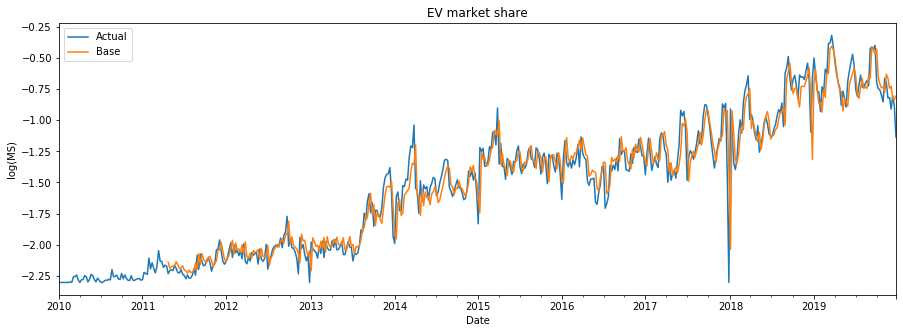

In [159]:
fig, ax = plt.subplots()

df_sales["log_ev_share"].plot(figsize=(15,5))
pred_sales_baseline.plot(figsize=(15,5))

### Add legend
plt.legend(('Actual', 'Base'))

### Add axis label and header
ax.set_ylabel('log(MS)')
ax.set_xlabel('Date')
ax.set_title('EV market share')

### Adding exogeneous variables

In [174]:
df_inter

,Tesla,Nissan Leaf,Volkswagen e-Golf,Bmw I3,Kia Soul
date,,,,,
2010-01-03,1.139360,0.000000,0.0,0.000000,0.000000
2010-01-10,0.889256,0.000000,0.0,0.000000,0.000000
2010-01-17,0.889256,0.000000,0.0,0.000000,0.000000
2010-01-24,0.889256,0.000000,0.0,0.000000,0.000000
2010-01-31,1.111570,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...
2019-12-01,35.652174,3.913043,0.0,1.739130,0.434783
2019-12-08,30.000000,3.043478,0.0,0.869565,0.434783
2019-12-15,28.260870,3.043478,0.0,1.304348,2.173913


In [187]:
## Improved model

### Keeping n_test as was done in paper, but our database is weekly. 
n_test = 17*4

### Create baseline model using lags y(t-1) and y(t-12) as described in paper, but lag=52 because of weekly dataset
AR_improved_model = AutoReg(df_sales["log_ev_share"],
                              lags=[1, 52],
                              hold_back = n_test,
                              exog=df_inter[['Tesla', 'Nissan Leaf', 'Bmw I3']],
                              old_names=False)

### Fit model
AR_improved = AR_improved_model.fit()

### Predict values using model
pred_sales_improved = AR_improved.predict(start=n_test) 

### Print summary
AR_improved.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:             log_ev_share   No. Observations:                  522
Model:             Restr. AutoReg-X(52)   Log Likelihood                 261.240
Method:                 Conditional MLE   S.D. of innovations              0.136
Date:                  Thu, 10 Dec 2020   AIC                             -3.958
Time:                          23:57:12   BIC                             -3.894
Sample:                      04-24-2011   HQIC                            -3.933
                           - 12-29-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1658      0.051     -3.276      0.001      -0.265      -0.067
log_ev_share.L1      0.7115      0.032     22.436      0.000       0.649       0.774
log_ev_share.L52     0.2031      0.029      6.988      0.000       0.146       0.260
Tesla                0.0025      0.001      3.150      0.002       0.001       0.004
Nissan Leaf          0.0012      0.003      0.360      0.719      -0.005       0.008
Bmw I3               0.0082      0.005      1.517      0.129      -0.002       0.019
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0065           -0.0000j            1.0065           -0.0000
AR.2             1.0008           -0.1161j            1.0075           -0.0184
AR.3             1.0008           +0.1161j            1.0075            0.0184
AR.4             0.9831           -0.2322j            1.0101           -0.0369
AR.5             0.9831           +0.2322j            1.0101            0.0369
AR.6             0.9520           -0.3474j            1.0134           -0.0557
AR.7             0.9520           +0.3474j            1.0134            0.0557
AR.8             0.9070           -0.4596j            1.0168           -0.0746
AR.9             0.9070           +0.4596j            1.0168            0.0746
AR.10            0.8481           -0.5665j            1.0199           -0.0937
AR.11            0.8481           +0.5665j            1.0199            0.0937
AR.12            0.7760           -0.6661j            1.0227           -0.1129
AR.13            0.7760           +0.6661j            1.0227            0.1129
AR.14            0.6918           -0.7566j            1.0252           -0.1321
AR.15            0.6918           +0.7566j            1.0252            0.1321
AR.16            0.5966           -0.8364j            1.0274           -0.1514
AR.17            0.5966           +0.8364j            1.0274            0.1514
AR.18            0.4920           -0.9042j            1.0294           -0.1707
AR.19            0.4920           +0.9042j            1.0294            0.1707
AR.20            0.3795           -0.9587j            1.0311           -0.1900
AR.21            0.3795           +0.9587j            1.0311            0.1900
AR.22            0.2609           -0.9992j            1.0327           -0.2093
AR.23            0.2609           +0.9992j            1.0327            0.2093
AR.24            0.1381           -1.0248j            1.0341           -0.2287
AR.25            0.1381           +1.0248j            1.0341            0.2287
AR.26            0.0127           -1.0352j            1.0353           -0.2480
AR.27            0.0127           +1.0352j            1.0353            0.2480
AR.28    

In [188]:
from sklearn.metrics import mean_absolute_error

### Create test set with training data removed
df_sales_test = df_sales.iloc[n_test:,:]

### Calculate totall MAE
baseline_MAE = mean_absolute_error(df_sales_test["log_ev_share"], pred_sales_baseline)
improved_MAE = mean_absolute_error(df_sales_test["log_ev_share"], pred_sales_improved)

### Calculate totall improvement
overall_improvement = ((baseline_MAE-improved_MAE)/baseline_MAE)*100
overall_improvement

2.238340839117273

## Record of improvements
    interest_kw_env
- CO2 - worse
- CO2 bil - worse
- CO2 utslipp - worse
- Karbonavtrykk - +0.005%
- Luftkvalitet - +0.15%

    interest_kw_eco
- Elbil bompenger - worse
- Elbil avgift - worse
- Elbil pris - worse
- Elbil fordeler - worse
- bompenger - worse (statistically significant)

    interest_kw_ran
- Elbil lading - +0.2%
- Elbil ladestasjoner - +0.06%
- Ladestasjoner - worse
- Hurtiglading - + 0.017%
- Elbil rekkevidde worse

    interest_kw_vm
- Tesla +1.87%
- Nissan Leaf +0.84%
- Volkswagen e-Golf worse
- Bmw I3 + 0.87%
- Kia Soul worse
... improvements combined - 2.4%

Text(0.5, 1.0, 'EV market share')

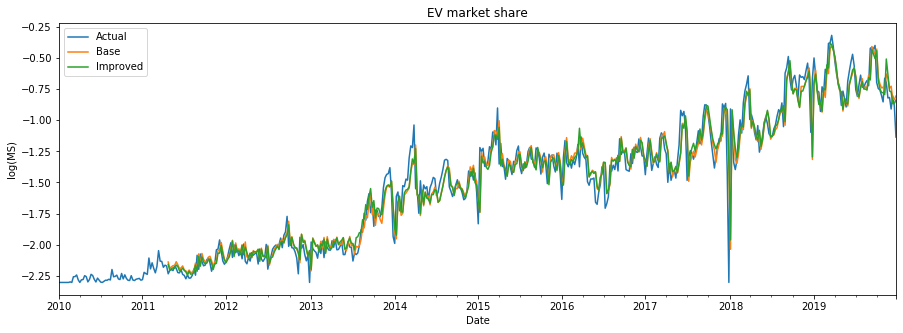

In [189]:
fig, ax = plt.subplots()

df_sales["log_ev_share"].plot(figsize=(15,5))
pred_sales_baseline.plot(figsize=(15,5))
pred_sales_improved.plot(figsize=(15,5))
### Add legend
plt.legend(('Actual', 'Base', 'Improved'))

### Add axis label and header
ax.set_ylabel('log(MS)')
ax.set_xlabel('Date')
ax.set_title('EV market share')